# Importing the necessary libraries

In [23]:
import functions

# 1. Hashing

## Hash Function

We first created a hash function capable of converting every single string into a unique value to avoid possible collisions. The dataset used contains over 560 thousand lines and consequently over half a million strings.To avoid collisions with over half a million strings we have set the maximum number of bits to 32 and consequently a modulo equal to 2<sup>32</sup>.

In [7]:
def hash(s, max_n_bit_hash_value=32):
    max_value = 1 << max_n_bit_hash_value # Define module equal to two to the thirty-second
    l = len(s) # len string
    h = 0
    for i in range(l): # For loop between 0 to len string
        h += s[i] ** (i+1) #For each character we increase "h". We compute for each character this power equation
        h %= max_value #After the power eqaution we divided the value of h by the module
    return h

## HyperLogLog structure

Once we have created the hash function valid for each string of our dataset. We have created the HyperLogLog class divided into four functions.
The *first function* represents an initialization for all the necessary variables in the HyperLogLog structure.
In the *second function* we apply all the variables set on the considered string.
Finally in the *last function* we return the cardinality value for the entire dataset.

The HyperLogLog class returns also the error against our filter.

In [13]:
import numpy as np
from math import sqrt, log

In [79]:
class HyperLogLog:
    def __init__(self, b=10, max_n_bit_hash_value=32):
        self.max_n_bit = max_n_bit_hash_value #We set the max number of bit for the hash value obtained before
        self.b = b 
        self.m = 2**b 
        self.M = np.full(self.m, 0) #An array with size equal to m initialized with all values equal to zero.
        self.a_m = 0.7213 / (1 + 1.079/self.m) #This value was obtained from a publication reported in our references. It is a value that depends only on m
        print('b:', b, "=> Error Filter:", 1.04/sqrt(self.m), '%')
    
    def add(self, s):
        x = hash(s, max_n_bit_hash_value=self.max_n_bit) #We apply our hash functon for each string that we put in input
        j = x >> (self.max_n_bit - self.b) #We define j as the value x obtained from the hash function divided by 2 raised to the difference between the maximum number of bits set for the hash function and the variable b chosen.
        w = x & 2**(self.max_n_bit - self.b) - 1 
        # w = x & (2**(self.max_n_bit - self.b) - 1) # possibile nuova versione, da verificare le precedenze degli operatori
        self.M[j] = max(self.M[j], self.rho(w, max_length=self.max_n_bit - self.b)) #For each element in array M we upload this with the max value between M[j] and value obtain with rho function.
    
    def rho(self, n, max_length): #?
        p = len(bin(n)[2:]) # Most significant bit in n
        return max_length - p + 1
    
    def card(self):
        Z = 1/np.sum(2.**-self.M) #It is equal to the sum of 2 raised by the opposite of each element belonging to the array M
        E = self.a_m * Z * self.m ** 2 #Cardinality defined by multiplication between the calculated variable Z and the two initialized variables (a_m and m)
        if E < 5.*self.m/2.:
            V = (self.M==0).sum() #Equal to the number of element in array M equal to 0
            if V==0: #If there isn't any element in array M equal to 0
                return E 
            else:
                return self.m*log(self.m*1./V) #The new cardinality is equal to the product of m (2 ** b) and the logarithm
        return E #Return Cardinality estimate with relative error

### Evaluation

Once we realized our Hash function and the HyperLogLog Structure, we took our dataset and carried out various tests to understand the best result that would minimize the Error Filter and increase the cardinality of the dataset.

The number of bit (b) affects the filter error.
We found out that max_n_bit_hash_value lower than 28 causes limitation in the cardinality so we decide to use max_n_bit_hash_value = 32.

In [82]:
HyperLogLog(10, 32) # b=10
HyperLogLog(12, 32) # b=12
hll = HyperLogLog(16, 32) # b=16

b: 10 => Error Filter: 0.0325 %
b: 12 => Error Filter: 0.01625 %
b: 16 => Error Filter: 0.0040625 %


In [6]:
f = open('./data/hash.txt', 'rb')

i=0
for line in f:
    line = line[:-1]
    hll.add(line)

f.close()

hll.card()

Error Filter: 0.0040625 %


124619088.0199604

Analyzing the various tests carried out, the filter error decreases as the number of bits obtained increases and this is normal since we know that our error filter is inversely proportional to the sqare root of the variable m which in turn is equal to the power of 2 raised to the number of bit.

For a number of bits equal to 16 we obtain an error filter equal to 0.004%.

Considering both cardinality and error filter we get the best result when we apply to the HyperLogLog Structure the number of bits equal to 16 and maximum number of bits equal to 32

# 2. Clustering

Our goal in this part of Homework is to define a KMeans Clustering algorithm from scratch considering the proposed Amazon Food dataset as the initial dataset. To do this it is necessary to prepare the dataset for Clustering. Preparation is strongly influenced by our choices, through the decision of which variables we are going to consider for the Clustering.

We choose "ProductId" and "Text" as columns of the dataset. By choosing these two columns it is necessary to represent the data (column Text) with TF-IDF to create a matrix where for each word we carry the tf-idf associated with each document.

## Pre-Processing dataset

### Visualization Dataset

In [30]:
import pandas as pd
from sklearn.cluster import KMeans as SK_KMeans
from matplotlib import pyplot as plt

In [3]:
reviews = pd.read_csv("./data/Reviews.csv")

In [4]:
reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


### Drop and save dataset

In this part we obtain a copy of the initial dataset that we call "new_dataset".

Using this new_dataset, we are going to drop all the columns that will not be useful for our analysis and so we are going to retain only the following columns:
- ProductId
- Text

In [5]:
product_text_dataset = reviews.copy()

In [6]:
product_text_dataset = product_text_dataset.drop(["Id","UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Summary", "Time"], axis=1)

In [7]:
product_text_dataset

,ProductId,Text
0,B001E4KFG0,I have bought several of the Vitality canned d...
1,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,This is a confection that has been around a fe...
3,B000UA0QIQ,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,Great taffy at a great price. There was a wid...
...,...,...
568449,B001EO7N10,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,These are the BEST treats for training and rew...


### Cleaning Text Columns

We are now going to clean the Text Columns using the nltk Library.

For the **clean_text** function, we first broke each signal string into tokens with the tokenizer. After this, we used the stopwords, the lemmatizer and the pos_tag from the nltk library.

With the lemmatizer we got the roots of each single word while with the pos_tag we decided to consider only the words belonging to the category adjectives, adverbs, nouns and verbs. Finally we got the modified string for each line.

In [ ]:
product_text_dataset["Text"] = product_text_dataset["Text"].apply(lambda text: (functions.clean_text(text)))

In [14]:
product_text_dataset

,index,ProductId,Text
0,0,B001E4KFG0,buy several vitality can dog food products fin...
1,1,B00813GRG4,product arrive label jumbo salt peanuts peanut...
2,2,B000LQOCH0,confection centuries light pillowy citrus gela...
3,3,B000UA0QIQ,look secret ingredient robitussin believe find...
4,4,B006K2ZZ7K,great taffy great price wide assortment yummy ...
...,...,...,...
568449,568449,B001EO7N10,great sesame chicken good better resturants ea...
568450,568450,B003S1WTCU,disappoint flavor chocolate note especially we...
568451,568451,B004I613EE,star small give train session try train dog ce...
568452,568452,B004I613EE,best treat train reward dog good groom lower c...


### Save new Dataset

Then we saved the dataset inside a csv file.

Before doing this we'll first check if any row in the dataset contains a null field in the Text column. This is necessary as we have to delete lines with null Text columns for the TFIDF Vectorizer.

In [21]:
functions.save_dataset(product_text_dataset)

In [15]:
# product_text_dataset = pd.read_csv("./data/CleanDatabase.csv")

Once we have this new dataset, we are going to join all the texts corresponding to each single ProductId.

In [16]:
product_text_dataset = product_text_dataset.groupby('ProductId', as_index = False).agg({'Text': ' '.join})

## Tf-Idf Vectorizer 

Once we got clean texts for each row of the dataset we applied from the Scikit Learn library the TFIDFVectorizer. Thanks to this we got a matrix that contains in the rows all the words in the dataset (in numeric format) and as columns all the documents belonging to the dataset.

For each word / document, if that word is in the considered document, we report the TFIDF value.

In [17]:
tfidf = functions.tfidf_vectorizer(product_text_dataset)

### Trade OFF Number Components - Variance

Once we have applied the TFIDF method, we have realized that tens of thousands of words compose our vocabulary.

For this reason we decided to reduce the dimensionality of the dataset using the SVDMethod.

Before doing this we need to find the correct number of components that we are going to consider for the SVD Method. We are going to consider only those components which will return an aggregate variance of  at least 60.

To do this we solved this TRADEOFF between Components and Variance both analytically and graphically.

In [18]:
n_best_components = 950 # functions.best_compenents(tf_idf, 100, 10000, 60)

## SVD Method

Once we got the useful number of components, we were able to apply the SVDMethod.

In [28]:
X = functions.SVDMethod(tfidf, n_best_components) # KMeans input matrix

## KMeans

We built our KMeans algorithm by following this procedure:

### K-Means Clustering

1. Choose the number of clusters(K) and obtain the data points
2. Place the centroids c_1, c_2, ..... c_k randomly
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
     - find the nearest centroid(c_1, c_2 .. c_k) 
     - assign the point to that cluster 
     
     
5. for each cluster j = 1..k
     - new centroid = mean of all points assigned to that cluster


6. End

In [ ]:
class KMeans:
    def __init__(self, K, n_features, random_state=None):
        if random_state:
            np.random.seed(seed=random_state)
        self.K = K # Number of clusters
        self.f = n_features # Number of features
        self.centroids = np.random.rand(K, n_features) - 0.5 # Create the centroids using random value between -0.50 <= x < 0.50
        
    def fit(self, X, max_iter = 300, verbose=True, plot_cluster_evolution=False):
        self.centroids *= np.mean(X) # Scale the centroids to match the X
        n = X.shape[0] # n is the number of sample in X
        U = np.zeros(n) # U contains the cluster prediction
        
        inertia_values = [] # List containing the inertia values (used to plot the inertia evolution)
        changes_values = [] # List containing the number of changes occurred (used to plot the number of changes evolution)
        
        # Training loop
        for i in range(max_iter):
            U_old = np.copy(U) # U_old contains a backup of U, it's used to calculate the number of changes occurred and to check convergence
            U, inertia = self.predict(X, inertia=True)
            n_changes = np.sum(U != U_old) # calculate the number of sample that changed cluster
            
            # For each cluster we update the centroid coordinates
            for j in range(self.K): 
                filt = U == j
                if filt.any():
                    self.centroids[j] = np.mean(X[filt], axis=0) 
            
            # If verbose print evolution information
            if verbose:
                print('Iter:', i, 'Inerzia:', inertia, 'N. Changes:', n_changes)
            
            # If plot_cluster_evolution we store the inertia and the n_changes values
            if plot_cluster_evolution:
                inertia_values.append(inertia)
                changes_values.append(n_changes)
            
            
            if not n_changes: # If there are no changes it converges so break the loop
                break
            
        # If plot_cluster_evolution is true plot the inertia values and the n. changes values
        if plot_cluster_evolution:
            inertia_values = np.array(inertia_values)
            changes_values = np.array(changes_values)
            
            # Plot Inertia
            plt.figure(figsize=(16,7))
            plt.ylabel('Inertia', size=22)
            sns.lineplot(data=inertia_values)
            plt.xlabel('N. Iteration', size=20)
            plt.xticks(np.arange(inertia_values.shape[0]), np.arange(inertia_values.shape[0])+1)
            plt.show()
            
            # Plot n. changes
            plt.figure(figsize=(16,7))
            plt.ylabel('N. Changes', size=22)
            sns.lineplot(data=changes_values)
            plt.xlabel('N. Iteration', size=20)
            plt.xticks(np.arange(changes_values.shape[0]), np.arange(changes_values.shape[0])+1)
            plt.show()
        
        # then returns the inertia
        return inertia
    
    def calc_inertia(self, X):
        return self.predict(X, inertia=True)[1]
    
    def predict(self, X, inertia=False):
        n = X.shape[0] # n is the number of sample in X
        
        # Calculate the distances between each sample and each centroid
        dist = np.zeros((n, self.K)) # dist contains the distances between each sample and each centroid
        for i in range(n):
            for j in range(self.K):
                dist[i,j] = scipy.spatial.distance.euclidean(X[i], self.centroids[j]) # Calculate the euclidean distance between the sample X[i] and the centroid self.centroids[j]
        
        res = np.argmin(dist, axis=1) # Calculate, for each sample, the nearest centroid
        
        if inertia: 
            _inertia = np.sum(np.take_along_axis(dist, np.expand_dims(res, axis=-1), axis=-1)) # Calculate the inertia using the distance matrix
            return res, _inertia
        
        return res

Before continuing with the Clustering procedure on our algorithm, we searched for the best value of K (number of clusters).

We applied the elbow method to the KMeans algorithm obtained from the Scikit-Learn library.

To reduce the computation time in the search for this optimal K value, we have created a list where we selected for which values we should compute k. The list contains integer values that increase more and more up to a maximum value we set.

The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow (or something that is assimilated to it) of the curve as the number of clusters to use.

From the plot we obtained it is not possible to visualize a real elbow beyond which there is a radical flattening of the curve. Variations beyond which the trend of the curve begins to be almost linear can be found in a value of K equal to 12.

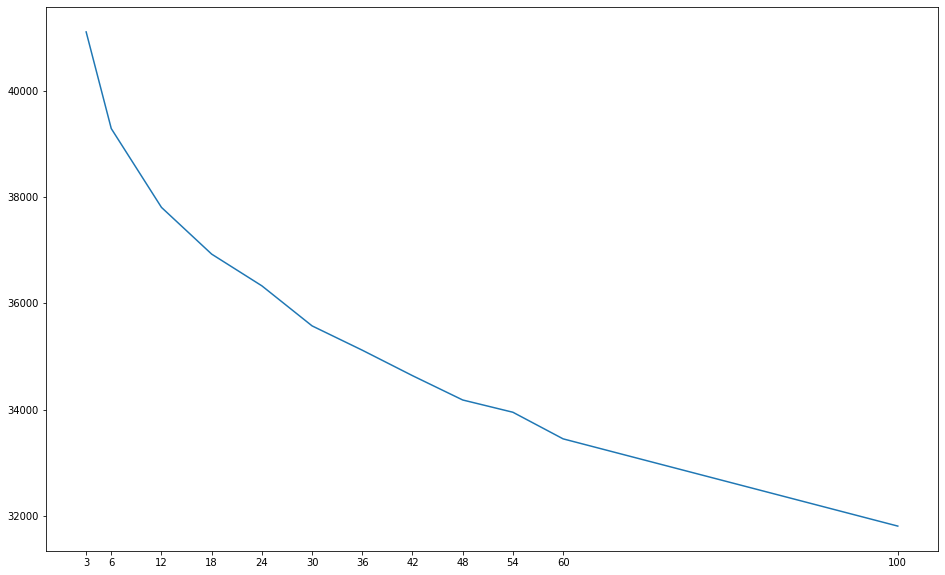

In [31]:
l = [3, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 100]
elbow = functions.elbow_method(X, l,  plot_result = False)
plt.figure(figsize=(16,10))
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.xticks(list(elbow.keys()))
plt.show()

We are now going to apply our KMeans algorithm and we will then compare it with the KMeans implemented on the Scikit-Learn library.

We decided to print two plots for our algorithm.

The first represents the trend of the inertia as the number of iterations varies. From this plot we can notice that in the first 10 iterations the inertia tends to drop more heavily and then stabilize with very slight variations.

In the second plot we represented the changes in each single iteration. Also in this case there are important changes in the first operations that converges to zero after few iterations.

Iter: 0 Inerzia: 57515.88372516383 N. Changes: 68833
Iter: 1 Inerzia: 54781.77785430216 N. Changes: 50471
Iter: 2 Inerzia: 53139.72150150524 N. Changes: 25415
Iter: 3 Inerzia: 52516.00408370479 N. Changes: 11630
Iter: 4 Inerzia: 52344.98064808454 N. Changes: 6514
Iter: 5 Inerzia: 52292.90442143423 N. Changes: 5106
Iter: 6 Inerzia: 52256.319069068864 N. Changes: 4352
Iter: 7 Inerzia: 52221.94096109343 N. Changes: 3974
Iter: 8 Inerzia: 52180.58377336367 N. Changes: 3198
Iter: 9 Inerzia: 52166.43983956486 N. Changes: 2206
Iter: 10 Inerzia: 52159.038438789124 N. Changes: 1598
Iter: 11 Inerzia: 52154.1631638533 N. Changes: 1141
Iter: 12 Inerzia: 52150.78384591656 N. Changes: 867
Iter: 13 Inerzia: 52148.307391809314 N. Changes: 622
Iter: 14 Inerzia: 52146.89835526543 N. Changes: 459
Iter: 15 Inerzia: 52145.84764530736 N. Changes: 370
Iter: 16 Inerzia: 52144.90605761145 N. Changes: 349
Iter: 17 Inerzia: 52143.72321837943 N. Changes: 331
Iter: 18 Inerzia: 52142.46846292276 N. Changes: 332
Iter

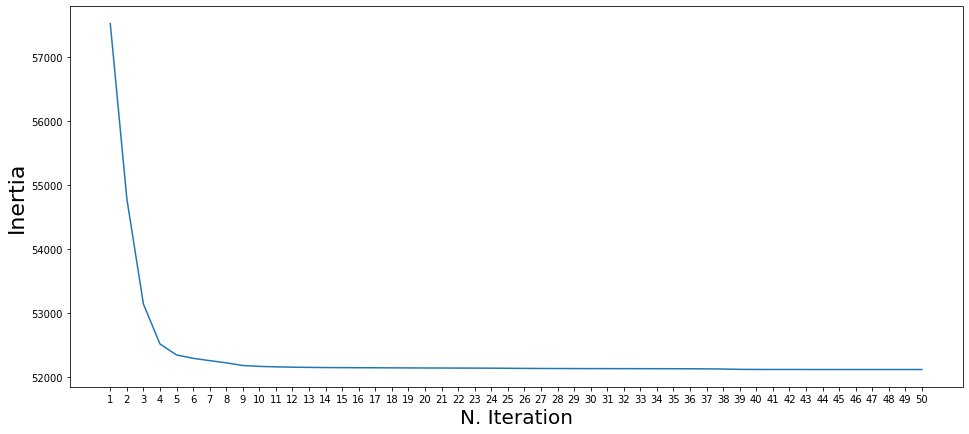

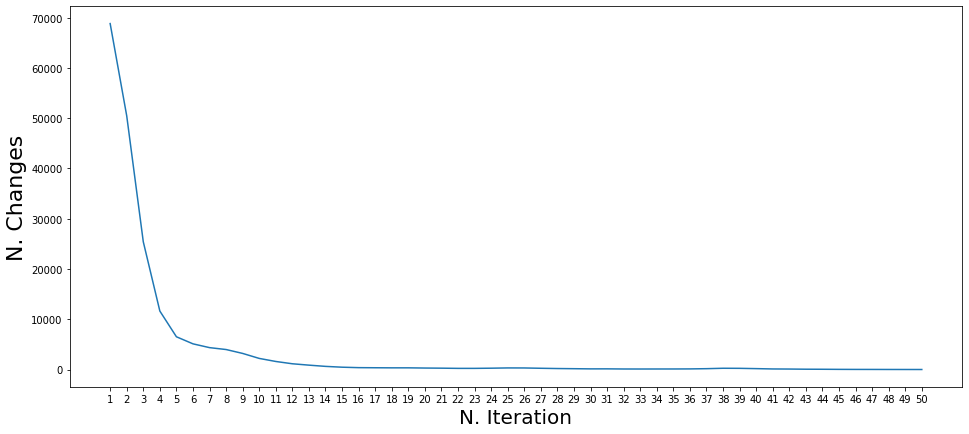

In [41]:
K = 12
our_model = functions.KMeans(K, n_best_components)
our_inertia = our_model.fit(X, plot_cluster_evolution=True)
our_prediction = our_model.predict(X)

Now we compare our implementation of the KMeans algorithm with the sklearn version.

In [77]:
sk_model = SK_KMeans(K).fit(X)
sk_inertia = sk_model.inertia_
sk_prediction = our_model.predict(X)

In [78]:
print('Our Inertia:', our_inertia, '\tSklearn Inertia:', sk_inertia)

Our Inertia: 52117.876791497365 	Sklearn Inertia: 37827.9459977803


The inertia of our model is much higher than the sklearn once because in KMeans++ the centroids are not decided randomly.

## Analyse the obtained clusters

Before answering what can be considered as our final considerations on the clusters we have obtained, it is necessary to do certain preliminary steps. Let's see them!

We store our_prediction in the clean dataframe using the column Cluster.

With the **complete_dataset** function we joined two different datasets: the initial dataset coming from the csv file Reviews and a second dataset which had only 3 columns - ProductId, the cleaned text (as we have seen beforehand) and the Cluster column to which each ProductId is associated.

Furthermore, on this last dataset we have obtained, we groupedBy on the ProductId and applied also a join on the ProductId column.

Finally, we have saved the dataset in a csv file. This was done in order not to have to compute all this preprocessing on the data everytime and so beeing more efficient. On this file we are going to work.


In [42]:
product_text_dataset['Cluster'] = our_prediction
product_cluster_dataset = product_text_dataset[['ProductId', 'Cluster']]

In [48]:
functions.store_complete_dataset(product_text_dataset)

In [49]:
complete_dataset = pd.read_csv("./data/Complete_dataset.csv")

In [50]:
complete_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cluster
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,6
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,6
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,6
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,6
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,4


### 2.3.1 Identify the kind of products in the cluster

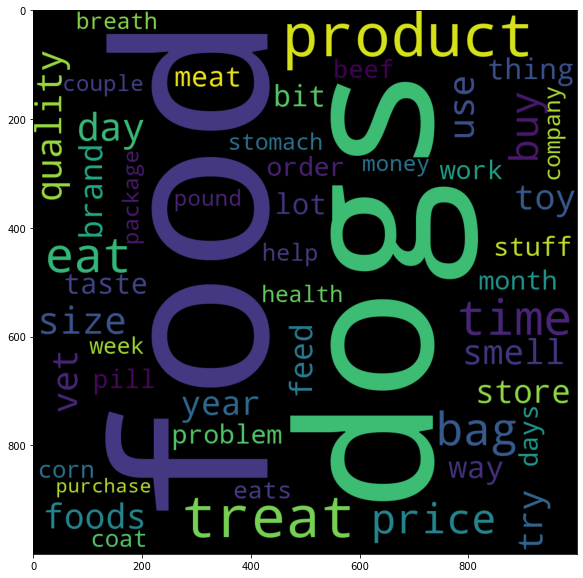

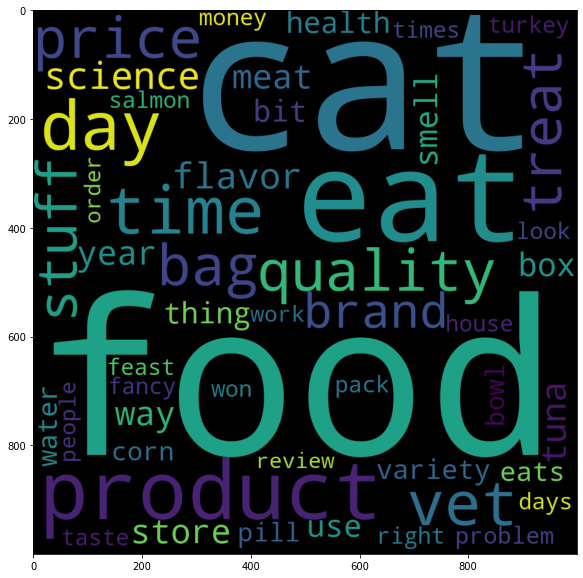

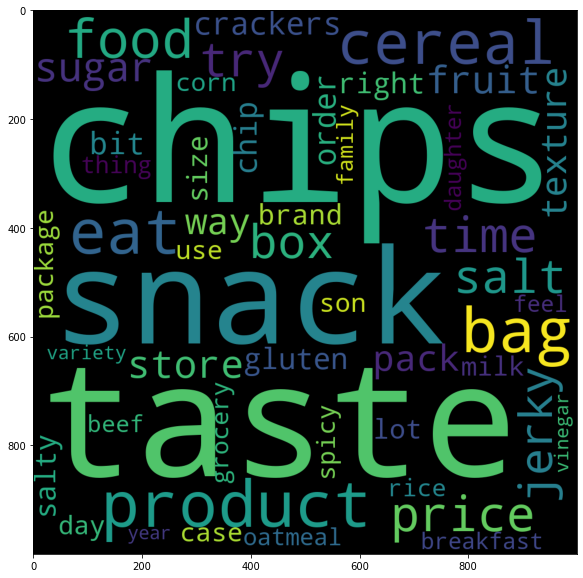

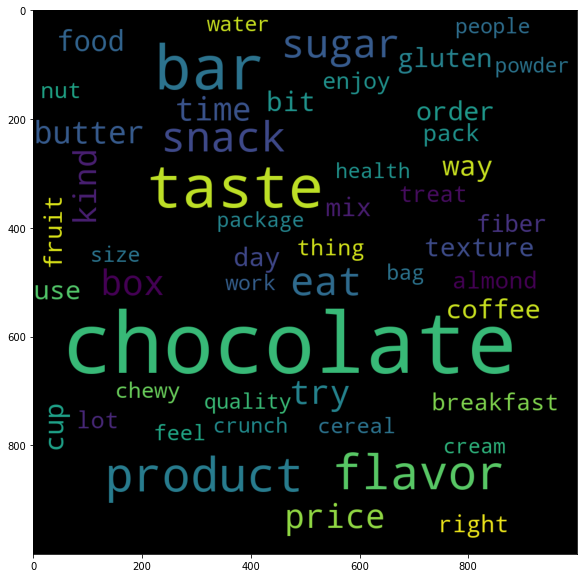

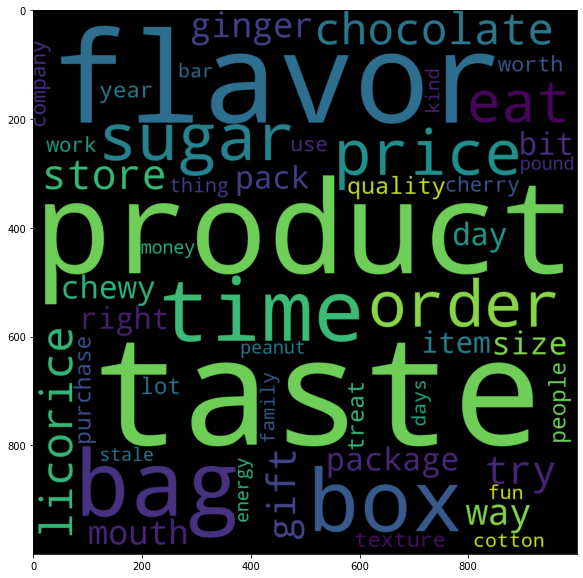

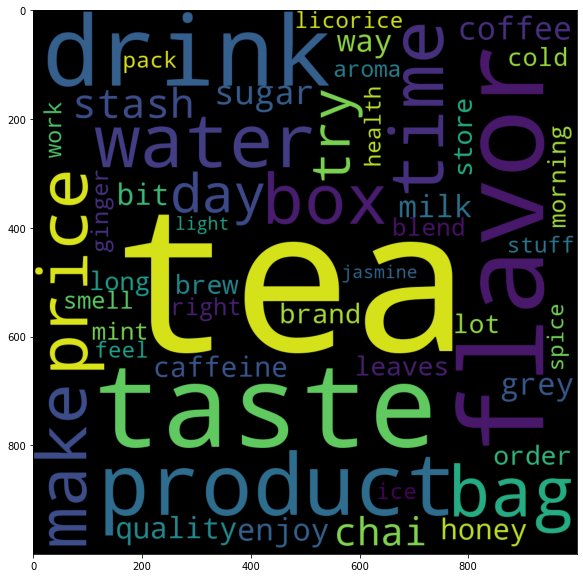

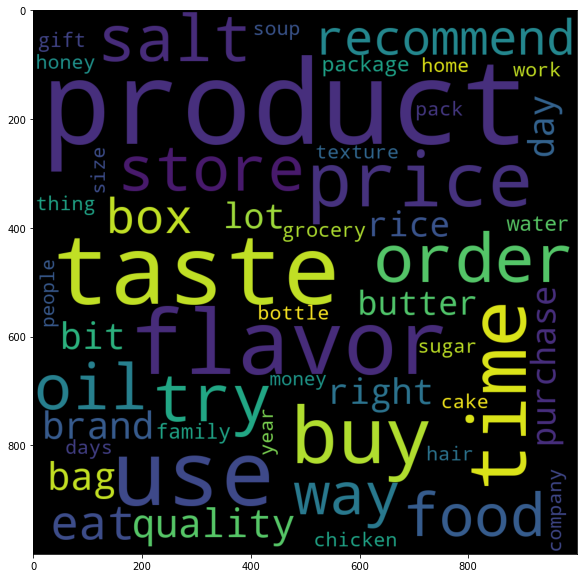

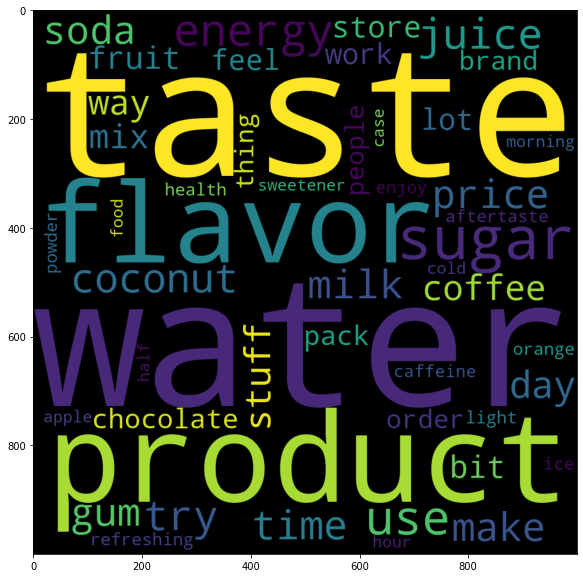

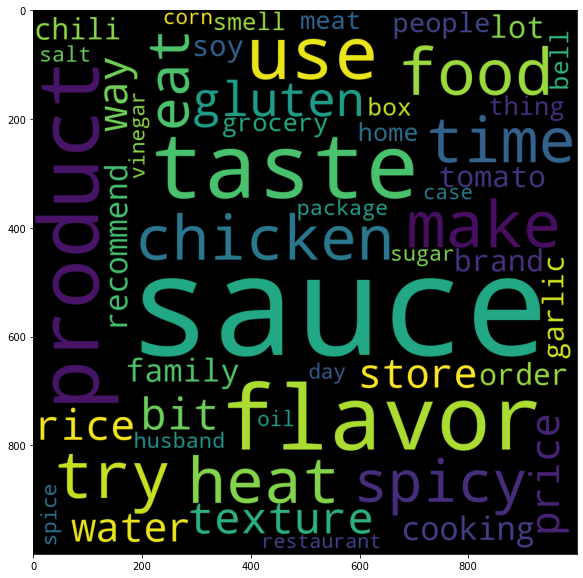

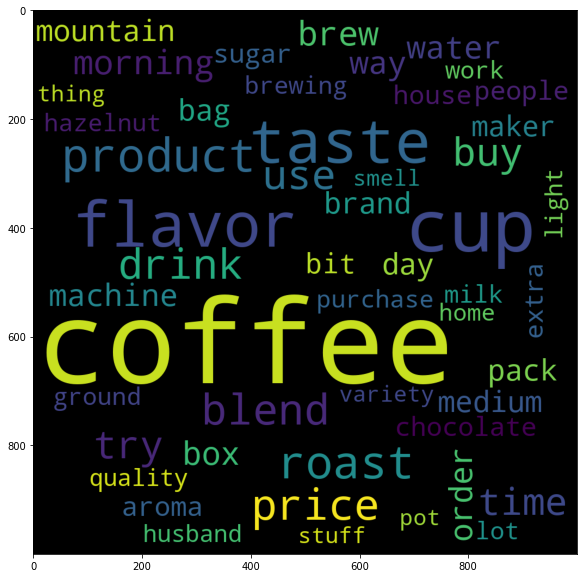

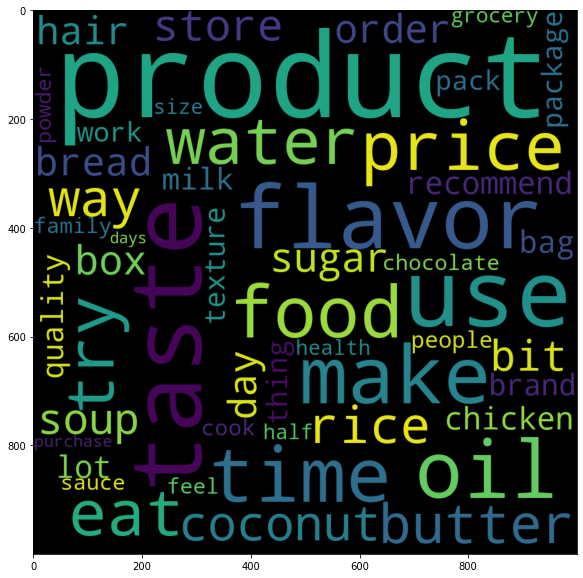

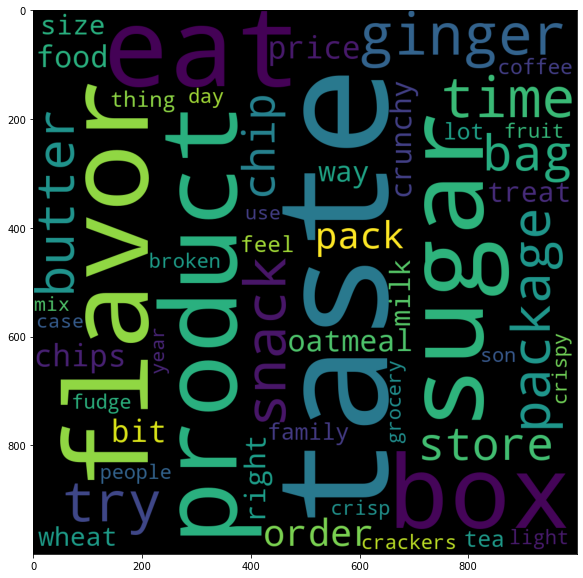

In [61]:
functions.show_word_cloud(complete_dataset)

### 2.3.2 Provide the number of product in each cluster

To answer this question, we first applied a GroupBy on the Cluster column. Once we did this, we counted the number of rows for each cluster which exactly matches the number of Products for each cluster.

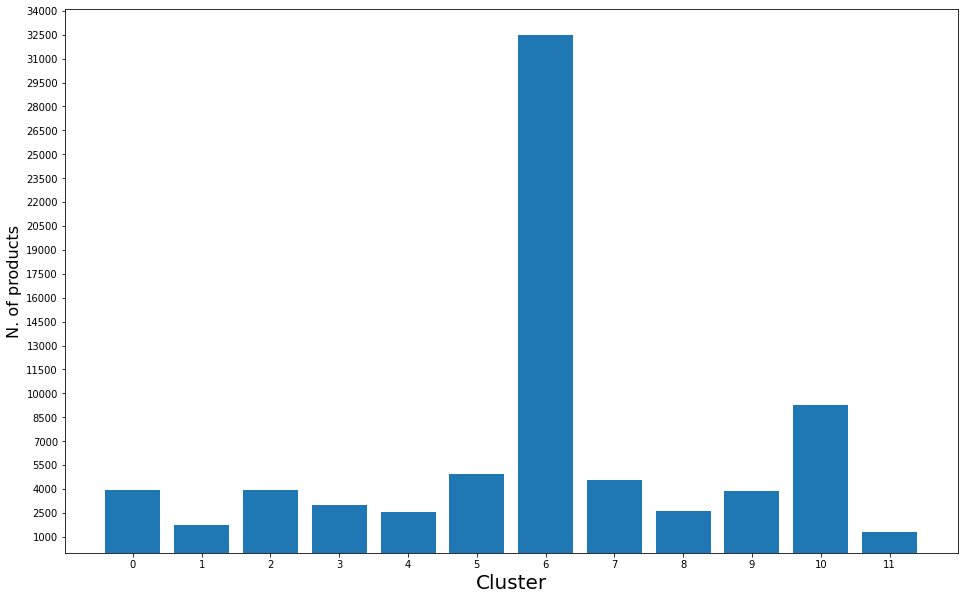

In [70]:
cluster_size = product_cluster_dataset.groupby('Cluster').size()
plt.figure(figsize=(16,10))
plt.xticks(cluster_size.index)
plt.yticks(range(1000, 50000, 1500))
plt.xlabel('Cluster', size=20)
plt.ylabel('N. of products', size=16)
plt.bar(cluster_size.index, cluster_size);

### 2.3.3 Compute the reviews' score distribution in each cluster

In order to calculate the distribution of the review score, we performed a for loop on the total number of clusters K. For each cluster we searched for the associated scores in the final dataset and we represented everything as a histogramm.

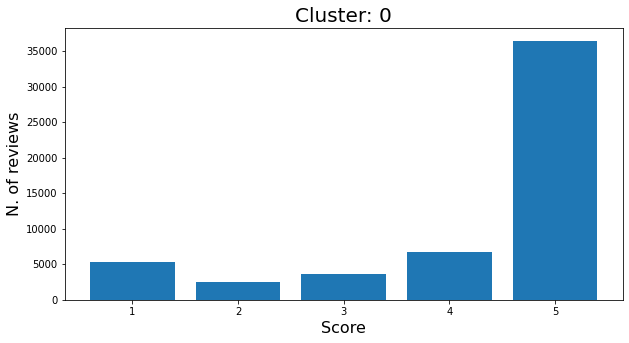

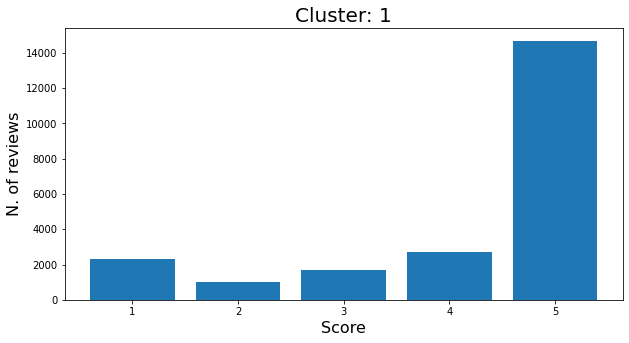

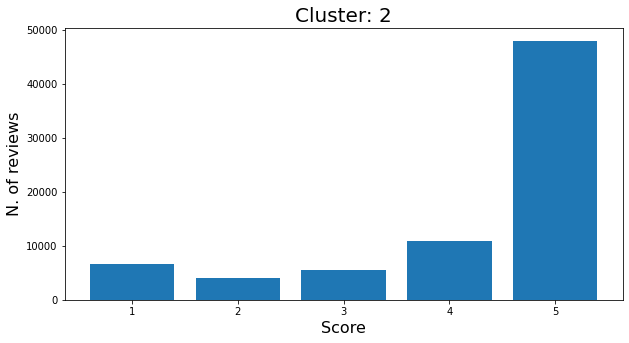

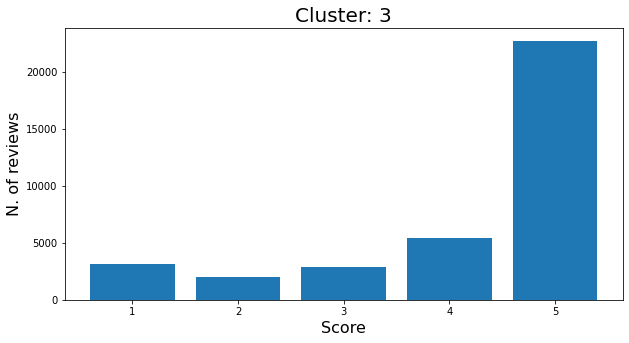

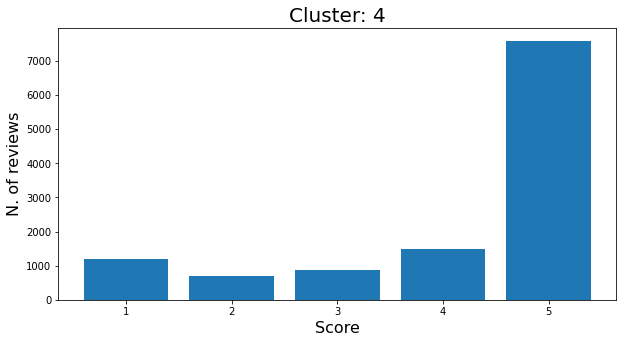

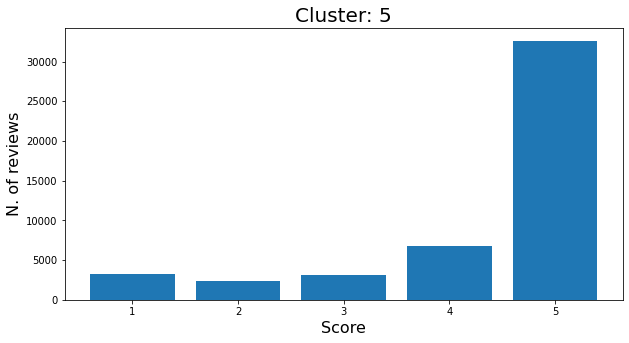

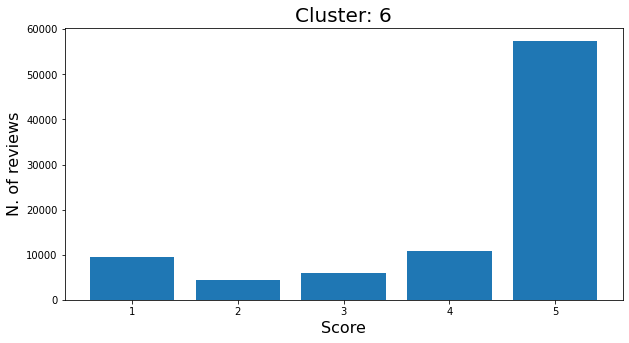

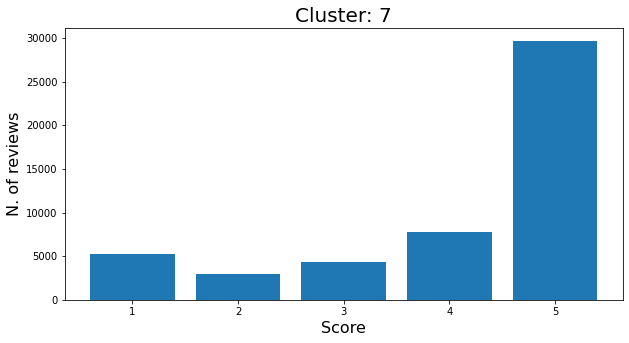

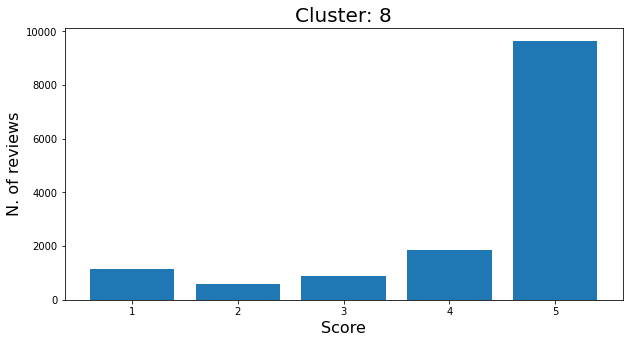

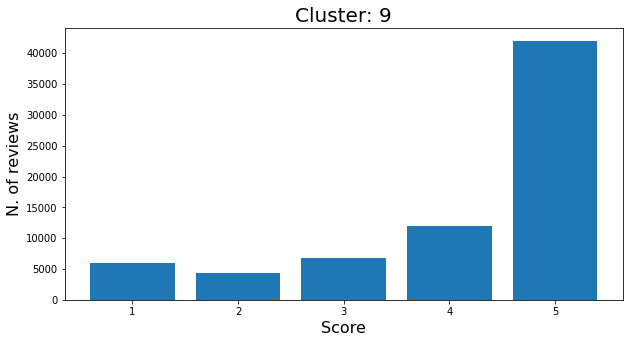

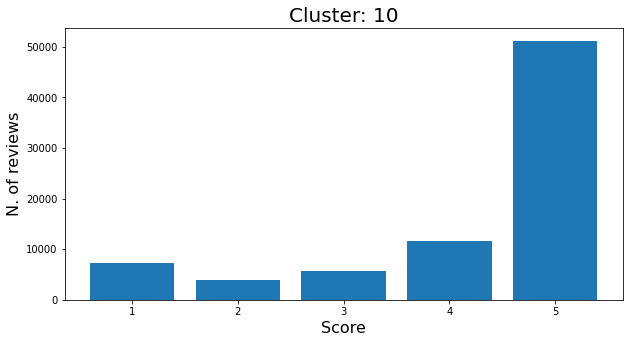

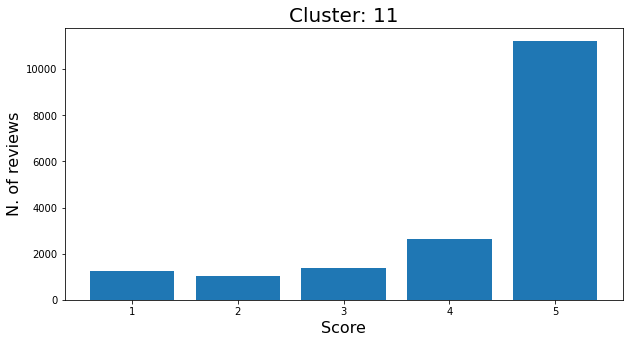

In [73]:
for cluster in range(K):
    fig = plt.figure(figsize=(10,5))
    plt.title('Cluster: '+str(cluster), size=20)
    plt.bar(np.arange(5)+1, complete_dataset[complete_dataset.Cluster == cluster].groupby('Score').size())
    plt.xlabel('Score', size=16)
    plt.ylabel('N. of reviews', size=16)
    plt.show()

Visually we can see that for each cluster we have a similar overall distribution. The only actual difference between the graphs can be found on the Total amount of views (y-axis).

### 2.3.4 Get the number of unique users writing reviews in each cluster

To search for the number of unique users writing reviews in each cluster, we carried out a GroupBy on the Cluster column and counted the unique UserId'sthrough the nunique command.

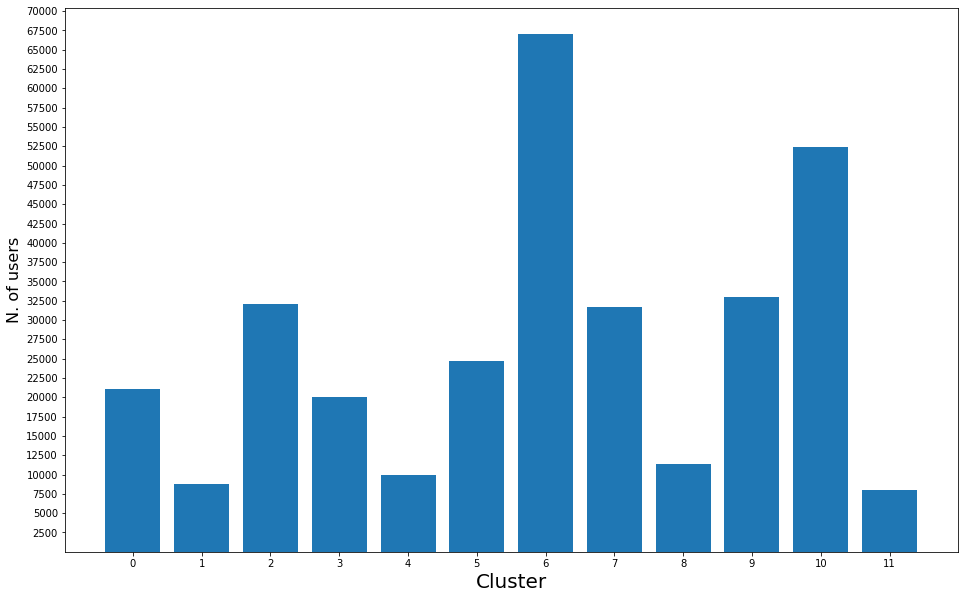

In [76]:
user_count = complete_dataset.groupby('Cluster').UserId.nunique()
plt.figure(figsize=(16,10))
plt.xticks(user_count.index)
plt.yticks(range(2500, 100000, 2500))
plt.xlabel('Cluster', size=20)
plt.ylabel('N. of users', size=16)
plt.bar(user_count.index, user_count);

# 3. Integer Sort

In [21]:
def integer_sort(A, n):

    #Find the maximum and the minimum given an array A has complexity O(n)
    s = min(A)
    b = max(A)
    
    #Allocate new array has time complexity O(1)
    r = int(b - s)
    pos_arr = new_array(value=0, dim=r)
    res = new_array(dim = n)
    idx = 0
    
    #This chunk loops n times over the array A so its comlexity is O(n)
    for i in range(1,n):
        p = A[i]
        pos_arr[p - s] += 1
        
    #This chunk loops r times over the array A so its comlexity is O(r) = O(b - s)
    for i in range(1,r):
        if pos_arr[i] != 0:
            for j in range(1,pos_arr[i]):
                res[idx] = i + s
                idx += 1
    return res

### Time Complexity


The algorithm complexity is $O(n + r) = O(n +(b - s))$

# References

 * For HyperLogLog structure: http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf